In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Code by Parag Mital (github.com/pkmital/CADL)
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

In [3]:
tf.reset_default_graph()

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [15]:
def sample_Z(n,m):
    return np.random.normal(-1.,1,size=[n,m])

def leaky_relu(x, slope=0.2):
    return max(slope,x)

In [6]:
def binary_cross_entropy(x, z):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

In [7]:
IMG_SIZE = 28
Z_DIM = 128

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

X = tf.placeholder(tf.float32, shape=[None,IMG_SIZE, IMG_SIZE])
Z = tf.placeholder(tf.float32, shape=[None, Z_DIM])

activation = tf.nn.relu

In [8]:
def generator(z, keep_prob=keep_prob, activation=activation, is_training=is_training):
    momentum = 0.99
    
    with tf.variable_scope('gen', initializer=tf.random_normal_initializer(stddev=0.02), reuse=tf.AUTO_REUSE):
    
        x = z
        x = tf.layers.dense(x, 4*4*2, activation=tf.nn.relu)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.reshape(x, shape=[-1, 4, 4, 2])
        x = tf.image.resize_images(x, size=[7, 7])
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        
    return x
        

In [9]:
def discriminator(x, keep_prob=keep_prob):
    
    with tf.variable_scope('disc', initializer=tf.random_normal_initializer(stddev=0.02), reuse=tf.AUTO_REUSE):
        
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, filters=5, kernel_size=[5,5], padding='SAME')
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=5, kernel_size=[5,5], padding='SAME')
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=3, kernel_size=[5,5], padding='SAME')
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x,128, tf.nn.relu)
        x = tf.layers.dense(x,1, tf.nn.sigmoid)
        
    return x

In [10]:
G_sample = generator(Z, keep_prob, tf.nn.relu, is_training)

In [11]:
D_real = discriminator(X)
D_fake = discriminator(G_sample)

In [12]:
vars_g = [var for var in tf.trainable_variables() if var.name.startswith('gen')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('disc')]

In [13]:
loss_D_real = binary_cross_entropy(tf.ones_like(D_real), D_real)
loss_D_fake = binary_cross_entropy(tf.zeros_like(D_fake), D_fake)
D_loss = tf.reduce_mean(binary_cross_entropy(tf.ones_like(D_fake), D_fake))
G_loss = tf.reduce_mean(0.5 * (loss_D_real + loss_D_fake))

d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    D_solver = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(D_loss + d_reg, var_list=vars_d)
    G_solver = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(G_loss + g_reg, var_list=vars_g)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

0 0.69333816 0.6931633


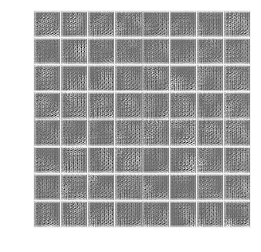

50 0.3572437 0.77272445
not training discriminator


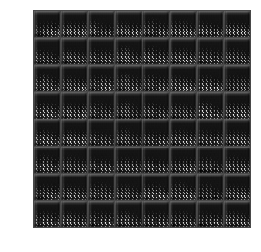

100 0.347168 0.70904016
not training discriminator


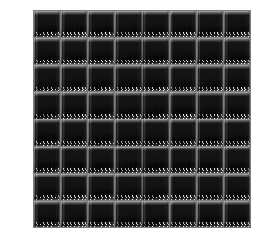

KeyboardInterrupt: 

In [14]:
BATCH_SIZE = 64
for i in range(60000):
    train_d = True
    train_g = True
    keep_prob_train = 0.6 # 0.5
    
    
    n = sample_Z(BATCH_SIZE, Z_DIM)
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=BATCH_SIZE)[0]]  
    
    loss_d, loss_g = sess.run([D_loss, G_loss], feed_dict={X: batch, Z: n, keep_prob: keep_prob_train, is_training:True})
    
    g_ls = loss_g
    d_ls = loss_d
    
    if g_ls * 1.5 < d_ls:
        train_g = False
        pass
    if d_ls * 2 < g_ls:
        train_d = False
        pass
    
    if train_d:
        sess.run(D_solver, feed_dict={Z: n, X: batch, keep_prob: keep_prob_train, is_training:True})
        
    if train_g:
        sess.run(G_solver, feed_dict={Z: n, X: batch, keep_prob: keep_prob_train, is_training:True})
            
    if not i % 50:
        print (i, d_ls, g_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(G_sample, feed_dict = {Z: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_img]
        m = montage(imgs)
        gen_img = m
        plt.axis('off')
        plt.imshow(gen_img, cmap='gray')
        plt.show()